In [1]:
!pip install dropbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.0/594.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00


In [2]:
import os
import io
import sys
import torch
import dropbox
import torchaudio
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

In [3]:
from torch.utils.data import random_split

In [4]:
!pip freeze > requirements.txt

In [5]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value = user_secrets.get_secret("dbx_token")

In [6]:
from google.colab import userdata
dbx_token = userdata.get('dbx_token')
dbx = dropbox.Dropbox(dbx_token)

In [7]:
# STREAM DATA FROM DROPBOX

def stream_data_from_dropbox(path):
  _, res = dbx.files_download(path)
  data = io.BytesIO(res.content)
  return data

In [8]:
audio_transcript_path="/Akan/selected transcribed audios/selected transcribed audios.xlsx"
audio_transcript_data = stream_data_from_dropbox(audio_transcript_path)
transcribed_audios_df = pd.read_excel(audio_transcript_data)

In [9]:
def avg_wer(wer_scores, combined_ref_len):
  return float(sum(wer_scores)) / float(combined_ref_len)

def levenshtein_distance(ref, hyp):
  m = len(ref)
  n = len(hyp)

  # Special Case
  if ref == hyp:
    return 0
  if m == 0:
    return n
  if n == 0:
    return m

  if m<n:
    ref, hyp = hyp, ref
    m, n = n, m


  distance = np.zeros((2, n+1), dtype=np.int32)

  # initialize distance matrix
  for j in range(0,n + 1):
      distance[0][j] = j

  # calculate levenshtein distance
  for i in range(1, m + 1):
      prev_row_idx = (i - 1) % 2
      cur_row_idx = i % 2
      distance[cur_row_idx][0] = i
      for j in range(1, n + 1):
          if ref[i - 1] == hyp[j - 1]:
              distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
          else:
              s_num = distance[prev_row_idx][j - 1] + 1
              i_num = distance[cur_row_idx][j - 1] + 1
              d_num = distance[prev_row_idx][j] + 1
              distance[cur_row_idx][j] = min(s_num, i_num, d_num)

  return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis,ignore_case=False, remove_space=False):
    if ignore_case == True:
      reference = reference.lower()
      hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''


    reference = join_char.join(filter(None,reference.split(' ')))
    hypothesis = join_char.join(filter(None, reference.split(' ')))



    edit_distance = levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [10]:
# def text_to_sequence(text, vocabularies):
#   return [vocabularies.get(char, vocabularies['<unk>']) for char in text]

In [11]:
characters_to_remove = ['Q', 'X', 'Ɔ','Ↄ',
  'A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z']

In [12]:
def build_vocab(transcripts, chars_to_remove):
  unique_chars = set()
  chars = set(''.join(transcripts))

  for char in chars:
    if char not in chars_to_remove:
      unique_chars.add(char)

  # Ensuring that special characters are not already part of the transcripts
  special_tokens = {'<pad>', '<unk>'}
  unique_chars = unique_chars.difference(special_tokens)

  char_to_id = {char: id + 1 for id, char in enumerate(sorted(unique_chars)) }
  char_to_id['<pad>'] = 0  # Padding token
  char_to_id['<unk>'] = len(char_to_id)  # Unknown token, for characters not in the vocabulary


  return char_to_id

vocab = build_vocab(transcribed_audios_df['Transcriptions'], characters_to_remove)

In [13]:
vocab

{' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ')': 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '/': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19,
 ':': 20,
 ';': 21,
 '=': 22,
 'C': 23,
 '[': 24,
 '\\': 25,
 'a': 26,
 'b': 27,
 'c': 28,
 'd': 29,
 'e': 30,
 'f': 31,
 'g': 32,
 'h': 33,
 'i': 34,
 'j': 35,
 'k': 36,
 'l': 37,
 'm': 38,
 'n': 39,
 'o': 40,
 'p': 41,
 'q': 42,
 'r': 43,
 's': 44,
 't': 45,
 'u': 46,
 'v': 47,
 'w': 48,
 'x': 49,
 'y': 50,
 'z': 51,
 'ä': 52,
 'Ɛ': 53,
 'ƒ': 54,
 'ɔ': 55,
 'ɛ': 56,
 'ʋ': 57,
 '‘': 58,
 '’': 59,
 '…': 60,
 'ℇ': 61,
 'ↄ': 62,
 '<pad>': 0,
 '<unk>': 63}

In [14]:
class TransformText:
  def __init__(self, vocab):
    self.vocab = vocab
    self.char_map = {}
    self.index_map = {}

    for ch, idx in vocab.items():
      self.char_map[ch] = int(idx)
      self.index_map[idx] = ch


  # CHANGING TEXT TO INT SEQUENCE
  def text_to_int_seq(self, text):
    text = text.lower()
    int_sequence = []

    for char in text:
      char = self.char_map[char]
      int_sequence.append(char)
    return int_sequence


  def int_to_text(self, labels):
    string = []
    for i in labels:
      string.append(self.index_map.get(i, '<unk>'))
    return ''.join(string)


text_transform = TransformText(vocab)

In [15]:
text_transform.text_to_int_seq("The young boy is calm")

[45,
 33,
 30,
 1,
 50,
 40,
 46,
 39,
 32,
 1,
 27,
 40,
 50,
 1,
 34,
 44,
 1,
 28,
 26,
 37,
 38]

In [16]:
text_transform.int_to_text([45, 33, 30, 1, 50, 40, 46, 39, 32, 1, 27, 40, 50, 1, 34, 44, 1, 28, 26, 37, 38])

'the young boy is calm'

In [17]:
class MyDataset(Dataset):
  def __init__(self, metadata_df, dbx_client):

    self.metadata_df = metadata_df
    self.dbx_client = dbx_client


  def __len__(self):
    return len(self.metadata_df)


  def __getitem__(self, idx):
    item = self.metadata_df.iloc[idx]

    audio_path = '/Akan/selected transcribed audios/audios/' + item['Full Filename'].lstrip('/')

    # STREAM AUDIO
    _, audio_res = self.dbx_client.files_download(path= audio_path)
    signal, sample_rate = torchaudio.load(io.BytesIO(audio_res.content))

    # # CONVERTING STEREO AUDIO TO MONO
    if signal.shape[0] == 2:
      signal = torch.mean(signal, dim=0, keepdim=True)

    transcript = item['Transcriptions']


    return signal, transcript

In [18]:
#FEATURE EXTRACTION

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

def data_processing(data, data_type="train"):
  spectrograms = []
  labels = []
  input_lengths = []
  label_lengths = []

  for (signal, label) in data:
    if data_type == 'train':
        spec = train_audio_transforms(signal).squeeze(0).transpose(0, 1)
    else:
        spec = valid_audio_transforms(signal).squeeze(0).transpose(0, 1)

    # NORMALIZE WAVEFORM
    spec = (spec - spec.mean()) / spec.std()
    spectrograms.append(spec)
    label = torch.Tensor(text_transform.text_to_int_seq(label.lower()))
    labels.append(label)
    input_lengths.append(spec.shape[0]//2)
    label_lengths.append(len(label))

  spectrograms = pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
  labels = pad_sequence(labels, batch_first=True)

  return spectrograms, labels, input_lengths, label_lengths

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [19]:
akan_dataset = MyDataset(transcribed_audios_df[:1000], dbx)
# akan_dataset = MyDataset(transcribed_audios_df[:500], dbx)

In [20]:
# USING ONLY 4 INSTANCES OF THE DATASET FOR TESTING PURPOSES
# ds = [akan_dataset.__getitem__(4+i) for i in range(4)]

In [21]:
# data_processing(ds, 'train')

#### **Splitting Dataset into Train, Test and Validation Set**

In [22]:
random_seed = 42
torch.manual_seed(random_seed)

In [23]:
len(akan_dataset)

1000

In [24]:
dataset_size = len(akan_dataset)
train_size = int(0.5*dataset_size)
val_size = int((dataset_size - train_size)*0.85)
test_size = int(dataset_size - train_size - val_size)

train_ds, test_ds, val_ds = random_split(akan_dataset, [train_size, test_size, val_size])

In [26]:
# DECODES THE OUTPUT OF THE PREDICTION
def GreedyDecoder(output, labels, label_lengths, blank_label=64, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

## **Model Building**

In [27]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.energy_layer = nn.Linear(hidden_size, 1)

    def forward(self, query, key, value):
        query = self.query_layer(query)
        key = self.key_layer(key)

        # Calculate energy scores
        energy = self.energy_layer(torch.tanh(query[:, None, :] + key))
        attention = torch.softmax(energy, dim=1)

        # Calculate context vector
        context = torch.sum(attention * value[:, None, :], dim=1)
        return context, attention

In [28]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
      # x (batch, channel, feature, time)
      x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
      x = self.layer_norm(x)
      return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

In [29]:
class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel,
                              stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel,
                              stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
#         print(f'x before transformation in rescnn: {x.shape}')
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
#         print(f'x after transformation in rescnn: {x.shape}')
        return x # (batch, channel, feature, time)

In [30]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalLSTM, self).__init__()

        self.BiLSTM = nn.LSTM(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiLSTM(x)
        x = self.dropout(x)
        return x

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2) # cnn for extracting hierarchical features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers1 = nn.Sequential(*[
            BidirectionalLSTM(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.birnn_layers2 = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])

        self.attention = BahdanauAttention(hidden_size=rnn_dim * 2)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
      x = self.cnn(x)
      x = self.rescnn_layers(x)
      sizes = x.size()
      x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
      x = x.transpose(1, 2) # (batch, time, feature)
      x = self.fully_connected(x)
      x = self.birnn_layers1(x)
      x = self.birnn_layers2(x)
      context, attention_weights = self.attention(x, x, x)
      x = self.classifier(context)
      return x

In [31]:
BATCH_MULTIPLIER = 8

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
checkpoint_path = '/content/drive/My Drive/ASR/'

In [34]:
def train(model, device, train_loader, criterion, optimizer, epoch,valid_loader,best_loss,curr_patience,best_val_loss):
    model.train()
    data_len = len(train_loader)
    train_loss = 0
    avg_train_loss = 0
    correct_predictions = 0
    total_predictions = 0
    scaler = GradScaler()


    optimizer.zero_grad()
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        # Enable autocast for the forward pass, automatically casting to mixed precision
        with autocast():
            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            loss = criterion(output, labels, input_lengths, label_lengths)

        scaler.scale(loss).backward()
        train_loss += loss.item()

        if (batch_idx + 1) % BATCH_MULTIPLIER == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            torch.cuda.empty_cache()


        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_wer, avg_val_loss = valid(model, device, valid_loader, criterion, epoch)

    try:
      #checking if current WER is better
      if avg_wer < best_loss:
          curr_patience=0
          best_loss = avg_wer
          #save model dicts
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'avg_wer':avg_wer
                }, '/content/drive/My Drive/ASR/model_path_wer.pth.tar')

      else:
          curr_patience+=1
          print("...No improvement in validation WER from {}...".format(best_loss))
      if avg_val_loss < best_val_loss:
          print("Improvement in main loss. Saving model weights to model_path_loss ")
          curr_patience=0
          best_val_loss = avg_val_loss
          #save model dicts
          torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'average_val_loss':avg_val_loss
                }, '/content/drive/My Drive/ASR/model_path_loss.pth.tar')
    except Exception as e:
      print(f"Failed to save the model due to {e}")

    return best_loss, curr_patience, best_val_loss, avg_train_loss,avg_wer, avg_val_loss



def valid(model, device, val_loader, criterion, epoch):
    print('\nEvaluating...')
    model.eval()
    val_loss = 0
    val_cer, val_wer = [], []
    val_losses = []
    correct_predictions = 0
    total_predictions = 0


    with torch.no_grad():
      for i, _data in enumerate(val_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        val_loss += loss.item()

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
        for pred, target in zip(decoded_preds, decoded_targets):
            if pred == target:
                correct_predictions += 1
            total_predictions += 1

        for j in range(len(decoded_preds)):
            val_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            val_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    print(f'decoded_preds: {decoded_preds}')
    valid_accuracy = 100 * correct_predictions / total_predictions
    avg_val_loss = val_loss/len(val_loader)
    avg_cer = sum(val_cer)/len(val_cer)
    avg_wer = sum(val_wer)/len(val_wer)


    print('Valid set: Average loss: {:.4f}, Accuracy: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(avg_val_loss, valid_accuracy, avg_cer, avg_wer))
    return avg_wer, avg_val_loss


# def test(model, device, test_loader, criterion, epoch):
#     model.eval()
#     test_loss = 0
#     test_cer, test_wer = [], []

#     with torch.no_grad():
#         for i, _data in enumerate(test_loader):
#             spectrograms, labels, input_lengths, label_lengths = _data
#             spectrograms, labels = spectrograms.to(device), labels.to(device)

#             output = model(spectrograms)  # (batch, time, n_class)
#             output = F.log_softmax(output, dim=2)
#             output = output.transpose(0, 1) # (time, batch, n_class)

#             loss = criterion(output, labels, input_lengths, label_lengths)
#             test_loss += loss.item() / len(test_loader)

#             decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
#             for j in range(len(decoded_preds)):
#                 test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
#                 test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


#     avg_cer = sum(test_cer)/len(test_cer)
#     avg_wer = sum(test_wer)/len(test_wer)


#     print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


In [35]:
def plot_metrics(TRAIN_LOSSES,VALID_LOSSES,VALID_WER):
    epochs = range(1, len(TRAIN_LOSSES) + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, TRAIN_LOSSES, label='Training Loss')
    plt.plot(epochs, VALID_LOSSES, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, VALID_WER, label='Validation WER')
    plt.title('Validation Word Error Rate')
    plt.xlabel('Epoch')
    plt.ylabel('WER')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [36]:
def main(learning_rate, batch_size, epochs, train_ds, valid_ds, test_ds, resume=False):
    hparams = {
        "n_cnn_layers": 7,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 65,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }


    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")


    # Creating DataLoaders for the Train, Test and Validation Datasets
    kwargs = {'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_ds,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x,'train'),
                                **kwargs)
    valid_loader = DataLoader(dataset=val_ds,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)
    test_loader = DataLoader(dataset=test_ds,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'test'),
                                **kwargs)

    model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)


    optimizer = optim.Adam(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=64, zero_infinity=True).to(device)

    start_epoch = 1
    best_loss = float('inf')
    best_val_loss = float('inf')
    curr_patience = 0
    patience = 5

    if resume:
        checkpoint = torch.load('/content/drive/My Drive/ASR/model_path_wer.pth.tar')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['val_loss']


#     checkpoint = torch.load(model_path_loss = '/kaggle/working/model.pth.tar')
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch_saved = checkpoint['epoch']
#     best_test_loss = checkpoint['val_loss']


    train_losses = []
    val_losses = []
    val_wer = []
    for epoch in range(start_epoch, epochs + 1):
        best_loss, curr_patience, best_val_loss, tra_losses, valid_wer, valid_losses = train(model, device, train_loader, criterion, optimizer,
                                                                                            epoch, valid_loader, best_loss, curr_patience, best_val_loss)
        train_losses.append(tra_losses)
        val_losses.append(valid_losses)
        val_wer.append(valid_wer)

        if curr_patience >= patience:
            print("Early stopping with patience of {}".format(patience))
            break
    #test(model, device, test_loader, criterion, epoch)


    # Plot loss curves
    plot_metrics(train_losses, val_losses, val_wer)

In [37]:
learning_rate = 0.001
batch_size = 4
epochs = 10

Train Epoch: 1 [0/125 (0%)]	Loss: 43.235374
Train Epoch: 1 [400/125 (80%)]	Loss: 48.884247

Evaluating...
decoded_preds: ['ℇb…c…=…ℇ…Ɛb…c…j7<unk>c<unk>…c…du…ℇ…ℇbc…kℇ7…uc7…b…bℇ<unk>bcℇ…b…c…bℇ…bc…cℇ…ℇc…7…c…c…7…j…<unk>k…c…ℇ…c…u…ux…Ɛ…b<unk>…c…c<unk>…k…bjbc…ℇ…b…=d7cb…7c…)…ℇ…u…xℇ…x…c7…)…ℇ…u…b…cℇc…7…b…c…u…u…c…u…c…ucu…7=…b…7=7…=…ℇuℇƐb…b…bj…jb<unk>…Ɛc…c7…ℇ…Ɛc…c…c…c…c…c…<unk>Ɛc…!7…7…c…x…u=u=kℇxℇ…<unk>=b…u…uc…c…=…u…7u<unk>ℇc…u…7u7u…u…u…c7cu…c…u…c…ℇ…7…ℇu…c…jℇ…bc…ℇ…u…u…u…=ℇ…<unk>…<unk>…c…<unk>c<unk>…<unk>…j7…ℇ…c<unk>7Ɛc7…c…ℇ7c…u…b…ub7u7…ℇ…ℇ…ududuℇcℇc…ℇuℇ…ℇ…ℇ…c…x…ucu…c7…7…uc=…uℇ…u…<unk>jc…c7…7…ℇ…7ℇ=ℇ…<unk>…c…c…c…<unk>7c7…c…c…ℇ…b…']
Valid set: Average loss: 50.2398, Accuracy: 0.0000, Average CER: 0.000000 Average WER: 1.0000

Failed to save the model due to Parent directory /content/drive/My Drive/ASR does not exist.
Train Epoch: 2 [0/125 (0%)]	Loss: 61.949299
Train Epoch: 2 [400/125 (80%)]	Loss: 44.312008

Evaluating...
decoded_preds: ['ℇb…c…=…ℇ…Ɛb…c…j7<unk>c<unk>…c…du…ℇ…ℇbc…kℇ7…uc7…b…bℇ<unk>bcℇ…b…c…

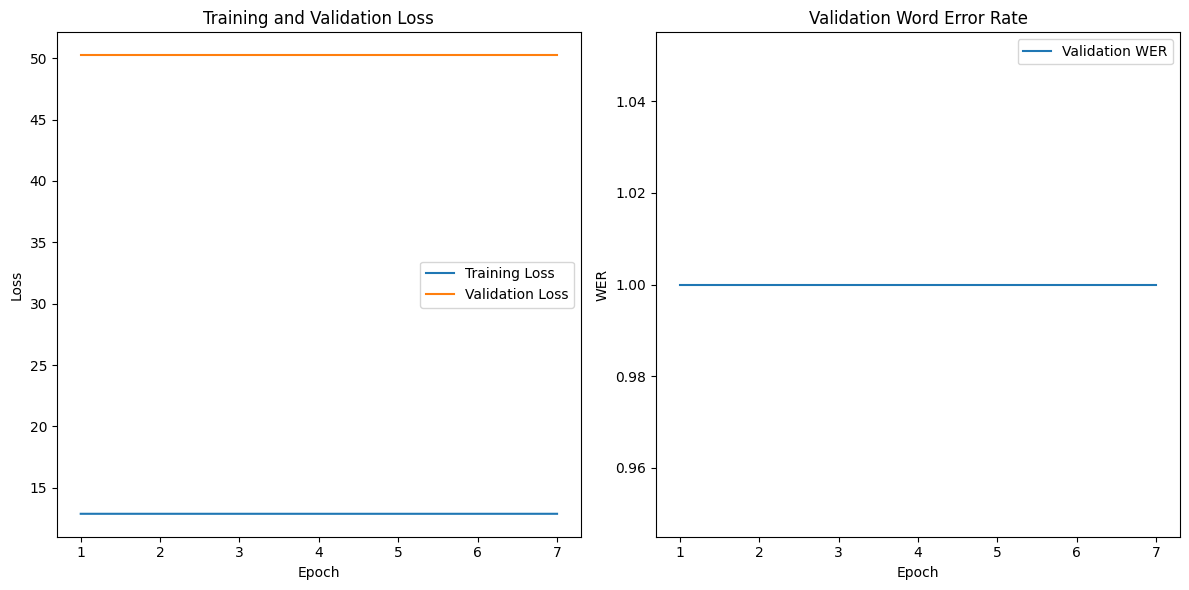

In [38]:
main(learning_rate, batch_size, epochs, train_ds, val_ds, test_ds)

In [ ]:
main(learning_rate, batch_size, epochs, train_ds, val_ds, test_ds, resume = True)

In [ ]:
learning_rate = 0.001
batch_size = 4
epochs = 5

HERE!!!!
Train Epoch: 1 [0/50 (0%)]	Loss: 53.767513
Train Epoch: 1 [25/50 (1%)]	Loss: 6.143878
Train Epoch: 1 [50/50 (2%)]	Loss: 3.103143
Train Epoch: 1 [75/50 (3%)]	Loss: 3.231107
Train Epoch: 1 [100/50 (4%)]	Loss: 2.984173
Train Epoch: 1 [125/50 (5%)]	Loss: 3.020020
Train Epoch: 1 [150/50 (6%)]	Loss: 3.010161
Train Epoch: 1 [175/50 (7%)]	Loss: 2.924320
Train Epoch: 1 [200/50 (8%)]	Loss: 2.900684
Train Epoch: 1 [225/50 (9%)]	Loss: 2.985230


evaluating…
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
decoded_preds: ['', '', '', '', '']
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
tensor([64, 64, 64,  ..., 64, 64, 64], device='cuda:0')
t

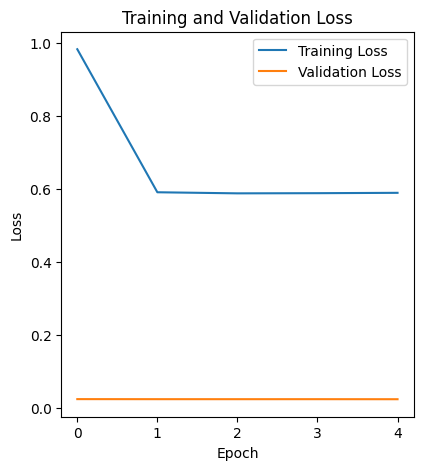

In [ ]:
main(learning_rate, batch_size, epochs, train_ds, test_ds)

Train Epoch: 1 [0/50 (0%)]	Loss: 20.851820

Train Epoch: 1 [50/50 (10%)]	Loss: 14.406153

Train Epoch: 1 [100/50 (20%)]	Loss: 5.024222

Train Epoch: 1 [150/50 (30%)]	Loss: 5.379881

Train Epoch: 1 [200/50 (40%)]	Loss: 3.598843

Train Epoch: 1 [250/50 (50%)]	Loss: 3.345028

Train Epoch: 1 [300/50 (60%)]	Loss: 3.188621

Train Epoch: 1 [350/50 (70%)]	Loss: 3.075439

Train Epoch: 1 [400/50 (80%)]	Loss: 3.121321

Train Epoch: 1 [450/50 (90%)]	Loss: 3.085147





evaluating…

Test set: Average loss: 3.0403, Average CER: 1.000000 Average WER: 1.0000



Train Epoch: 2 [0/50 (0%)]	Loss: 3.056879

Train Epoch: 2 [50/50 (10%)]	Loss: 3.109380

Train Epoch: 2 [100/50 (20%)]	Loss: 3.049210

Train Epoch: 2 [150/50 (30%)]	Loss: 3.020334

Train Epoch: 2 [200/50 (40%)]	Loss: 3.025685

Train Epoch: 2 [250/50 (50%)]	Loss: 3.050107

Train Epoch: 2 [300/50 (60%)]	Loss: 3.022088

Train Epoch: 2 [350/50 (70%)]	Loss: 3.107831

Train Epoch: 2 [400/50 (80%)]	Loss: 3.039391

Train Epoch: 2 [450/50 (90%)]	Loss: 3.

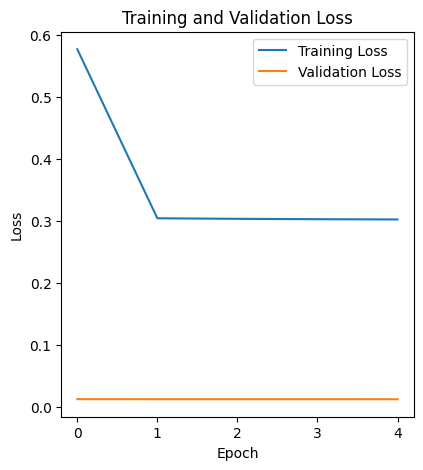

In [ ]:
main(learning_rate, batch_size, epochs, train_ds, test_ds)